In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prompt_toolkit.key_binding.bindings.named_commands import self_insert
#데이터 증강에 필요한 라이브러리
from scipy.ndimage import median_filter, rotate, shift
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

from lab1.d import xgb_reg

### 패딩 조져서 60,60 ->: 3600으로 만들고 kernel size = 8 stride = 4로 커널이 지나가면서 통예수치 추출 이하 생략.,

In [2]:
df = pd.read_pickle("/home/unsi/다운로드/LSWMD.pkl")
df

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]
...,...,...,...,...,...,...
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]]
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]]
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,[[Test]],[[Edge-Ring]]
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,1.0,[],[]


In [3]:
df['waferMap'][0].shape

(45, 48)

In [4]:
# failureType 열의 데이터 유형과 샘플 값 확인
print(df['failureType'].head(50))  # 상위 50개의 데이터를 확인


0         [[none]]
1         [[none]]
2         [[none]]
3         [[none]]
4         [[none]]
5         [[none]]
6         [[none]]
7         [[none]]
8         [[none]]
9         [[none]]
10        [[none]]
11        [[none]]
12        [[none]]
13        [[none]]
14        [[none]]
15        [[none]]
16        [[none]]
17        [[none]]
18        [[none]]
19         [[Loc]]
20        [[none]]
21        [[none]]
22        [[none]]
23        [[none]]
24        [[none]]
25        [[none]]
26        [[none]]
27        [[none]]
28        [[none]]
29        [[none]]
30        [[none]]
31        [[none]]
32        [[none]]
33        [[none]]
34        [[none]]
35              []
36    [[Edge-Loc]]
37    [[Edge-Loc]]
38    [[Edge-Loc]]
39    [[Edge-Loc]]
40         [[Loc]]
41    [[Edge-Loc]]
42    [[Edge-Loc]]
43    [[Edge-Loc]]
44      [[Center]]
45              []
46        [[none]]
47         [[Loc]]
48    [[Edge-Loc]]
49      [[Center]]
Name: failureType, dtype: object


In [5]:
passed = df[df['failureType'].apply(lambda x: x.shape == (0, 0) or x[0][0] == 'none')]
passed['failureType'] = 8
eda_pass = passed
passed = passed.sample(n=100000, random_state=42)
faild = df[df['failureType'].apply(lambda x: len(x) > 0 and len(x[0]) > 0 and x[0][0] != 'none')]
faild
class2idx = {
    'Loc': 0,
    'Edge-Loc': 1,
    'Center': 2,
    'Edge-Ring': 3,
    'Scratch': 4,
    'Random': 5,
    'Near-full': 6,
    'Donut': 7,
    'pass': 8
}

#failureType 인코딩 
faild['failureType'] = faild['failureType'].apply(lambda x: class2idx.get(x[0][0], -1))

# 결과 확인
faild
df = pd.concat([faild, passed])
df

/tmp/ipykernel_8157/1353984034.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passed['failureType'] = 8
/tmp/ipykernel_8157/1353984034.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  faild['failureType'] = faild['failureType'].apply(lambda x: class2idx.get(x[0][0], -1))


,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
19,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,20.0,[[Training]],0
36,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,12.0,[[Training]],1
37,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,13.0,[[Training]],1
38,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,14.0,[[Training]],1
39,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,15.0,[[Training]],1
...,...,...,...,...,...,...
334843,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",5532.0,lot20174,4.0,[],8
609203,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1,...",710.0,lot38319,13.0,[],8
244074,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2,...",648.0,lot15275,11.0,[],8
379250,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2393.0,lot22590,20.0,[],8


In [6]:
# failureType의 고유 값과 개수 세기
failure_counts = df['failureType'].value_counts()

print(failure_counts)

failureType
8    100000
3      9680
1      5189
2      4294
0      3593
4      1193
5       866
7       555
6       149
Name: count, dtype: int64


In [7]:
features = df['waferMap']
targets = df['failureType'].values
df = pd.concat([faild, passed])

In [8]:
features.shape

(125519,)

In [9]:
def apply_median_filter(wafer_map, size=3):
    return median_filter(wafer_map, size=size)


features = features.apply(lambda x: apply_median_filter(x, size=3))

In [10]:
df

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
19,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,20.0,[[Training]],0
36,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,12.0,[[Training]],1
37,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,13.0,[[Training]],1
38,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,14.0,[[Training]],1
39,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,15.0,[[Training]],1
...,...,...,...,...,...,...
334843,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",5532.0,lot20174,4.0,[],8
609203,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1,...",710.0,lot38319,13.0,[],8
244074,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2,...",648.0,lot15275,11.0,[],8
379250,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2393.0,lot22590,20.0,[],8


In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# 결함 유형 8을 새로운 라벨 7로 변환 (필요할 경우)


# 데이터 분할 (train, test split)
X_train, X_test, y_train, y_test = train_test_split(features, targets, stratify=targets, random_state=123,
                                                    test_size=0.2)

print(f"훈련 데이터 수: {X_train.shape[0]}, 테스트 데이터 수: {X_test.shape[0]}")

훈련 데이터 수: 100415, 테스트 데이터 수: 25104


In [12]:
X_test.shape, y_test.shape

((25104,), (25104,))

In [13]:
X_test.shape, y_test.shape

((25104,), (25104,))

In [14]:
X_train_no_aug = X_train
y_train_no_aug = y_train

In [15]:
X_train_no_aug = X_train_no_aug.values

In [16]:
import numpy as np


# 데이터 증강 함수 (Train 데이터만 증강)
def augment_data(wafer_maps, targets):
    augmented_maps = []
    augmented_targets = []

    # 원본 웨이퍼 맵의 크기 확인 (첫 번째 맵을 기준으로)
    original_shape = wafer_maps[0].shape

    for wafer_map, target in zip(wafer_maps, targets):
        # 원본 데이터 추가 (리사이즈 없이 그대로)
        augmented_maps.append(pad_or_crop(wafer_map, original_shape))  # 원본 데이터도 일관된 크기로 추가
        augmented_targets.append(target)

        # 결함 있는 웨이퍼만 증강 (라벨 8 제외)
        if target != 8:
            # 90도 회전
            rotated_90 = np.rot90(wafer_map, k=-1)
            rotated_180 = np.rot90(wafer_map, k=2)
            rotated_270 = np.rot90(wafer_map, k=1)

            # 상하 및 좌우 뒤집기
            flipped_vertical = np.flip(wafer_map, axis=0)
            flipped_horizontal = np.flip(wafer_map, axis=1)

            # 회전 및 뒤집기 후 동일한 크기 유지 확인 및 강제 조정
            augmented_maps.append(pad_or_crop(rotated_90, original_shape))
            augmented_targets.append(target)

            augmented_maps.append(pad_or_crop(rotated_180, original_shape))
            augmented_targets.append(target)

            augmented_maps.append(pad_or_crop(rotated_270, original_shape))
            augmented_targets.append(target)

            augmented_maps.append(pad_or_crop(flipped_vertical, original_shape))
            augmented_targets.append(target)

            augmented_maps.append(pad_or_crop(flipped_horizontal, original_shape))
            augmented_targets.append(target)

    # 웨이퍼 맵의 모양이 모두 같은지 확인 및 배열화
    augmented_maps = np.array([np.array(wafer, dtype=np.float32) for wafer in augmented_maps])

    return augmented_maps, np.array(augmented_targets)


def pad_or_crop(image, target_shape):
    """
    이미지의 크기가 target_shape와 동일하지 않은 경우, 잘라내거나 패딩을 추가하여 동일한 크기로 만듭니다.
    """
    current_shape = image.shape
    padded_image = np.zeros(target_shape, dtype=image.dtype)

    # 이미지의 크기가 목표 크기보다 작다면, 중앙에 위치하도록 패딩
    padded_image[:min(current_shape[0], target_shape[0]), :min(current_shape[1], target_shape[1])] = \
        image[:min(current_shape[0], target_shape[0]), :min(current_shape[1], target_shape[1])]

    return padded_image


# 증강된 훈련 데이터
X_train_aug, y_train_aug = augment_data(X_train_no_aug, y_train_no_aug)

print(f"증강된 훈련 데이터의 형태: {X_train_aug.shape}")


증강된 훈련 데이터의 형태: (202490, 52, 59)


In [17]:
import numpy as np


def pad_images_to_same_size(images, target_shape):
    """
    모든 이미지를 동일한 크기(target_shape)로 패딩합니다.
    이미지가 target_shape보다 큰 경우 잘라냅니다.
    """
    padded_images = []
    for image in images:
        # 현재 이미지의 크기 가져오기
        current_shape = image.shape

        # 패딩된 이미지를 0으로 초기화 (target_shape 크기로)
        padded_image = np.zeros(target_shape, dtype=image.dtype)

        # 이미지의 크기가 목표 크기보다 작다면, 중앙에 위치하도록 복사
        padded_image[:min(current_shape[0], target_shape[0]), :min(current_shape[1], target_shape[1])] = \
            image[:min(current_shape[0], target_shape[0]), :min(current_shape[1], target_shape[1])]

        padded_images.append(padded_image)

    return np.array(padded_images)


# 모든 이미지를 동일한 크기로 패딩
target_shape = (60, 60)  # 예시로 (52, 59)로 설정
X_train_no_aug = pad_images_to_same_size(X_train_no_aug, target_shape)
X_train_aug = pad_images_to_same_size(X_train_aug, target_shape)
X_test = pad_images_to_same_size(X_test, target_shape)


In [18]:
X_train_aug.shape

(202490, 60, 60)

In [19]:
import numpy as np


# 각 웨이퍼 맵에 대해 로그 변환을 개별적으로 적용
def apply_log1p_to_array(arr):
    return np.array([np.log1p(wafer) for wafer in arr])


# 로그 변환을 적용하여 0으로 인한 문제를 피하기 위해 np.log1p 사용 (log(1 + x))
X_train_no_aug = apply_log1p_to_array(X_train_no_aug)
X_test = apply_log1p_to_array(X_test)
X_train_aug = apply_log1p_to_array(X_train_aug)

# 결과 출력
print(X_train_aug[0])
print(X_train_no_aug[0])


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [20]:
print(X_train_aug.shape)

(202490, 60, 60)


In [21]:
y_train_aug.shape

(202490,)

In [22]:
import pandas as pd

# 결함 유형별 데이터 개수 세기
augmented_target_series = pd.Series(y_train_aug)
failure_counts_augmented = augmented_target_series.value_counts()

print("증강된 훈련 데이터의 결함 유형별 개수:")
print(failure_counts_augmented)

증강된 훈련 데이터의 결함 유형별 개수:
8    80000
3    46464
1    24906
2    20610
0    17244
4     5730
5     4158
7     2664
6      714
Name: count, dtype: int64


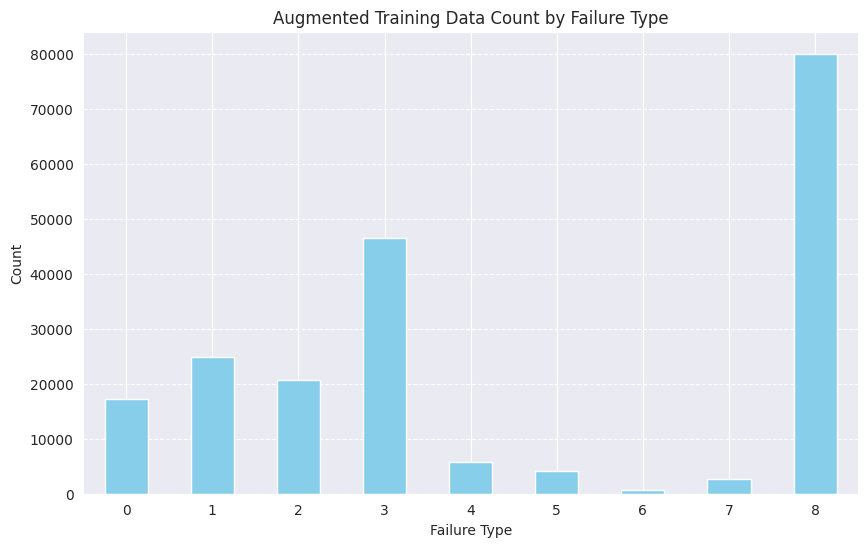

In [23]:
import matplotlib.pyplot as plt

# 결함 유형별 데이터 개수 그래프 그리기
plt.figure(figsize=(10, 6))
failure_counts_augmented.sort_index().plot(kind='bar', color='skyblue')
plt.title('Augmented Training Data Count by Failure Type')
plt.xlabel('Failure Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.show()

In [24]:
import numpy as np
import pandas as pd


# 특징 추출 함수
def extract_features(wafer_maps):
    features = []

    for wafer_map in wafer_maps:
        # 1. 결함 다이 비율
        total_pixels = wafer_map.size  # 전체 다이 개수
        defect_count = np.sum(wafer_map == 2)  # 2의 개수
        defect_ratio = defect_count / total_pixels if total_pixels > 0 else 0

        # 2. 결함 분포 (중앙값과 가장자리 근처에 집중되는지)
        defect_indices = np.argwhere(wafer_map == 2)  # 결함 위치의 인덱스
        if defect_indices.size > 0:
            center_of_defects = np.mean(defect_indices, axis=0)  # 결함 위치의 중앙
            distance_to_center = np.linalg.norm(defect_indices - center_of_defects, axis=1)  # 중앙에서의 거리
            avg_distance = np.mean(distance_to_center)  # 평균 거리
        else:
            center_of_defects = np.array([np.nan, np.nan])
            avg_distance = np.nan

        # 3. 픽셀 기반 통계 값 (평균 및 분산)
        mean_value = np.mean(wafer_map)
        variance_value = np.var(wafer_map)

        # 특징 추가
        features.append({
            'defect_ratio': defect_ratio,
            'center_of_defects': center_of_defects,
            'avg_distance_to_center': avg_distance,
            'mean_value': mean_value,
            'variance_value': variance_value
        })

    return pd.DataFrame(features)


# 특징 추출
features_df = extract_features(X_train_aug)

# 결과 확인
print(features_df.head())

   defect_ratio center_of_defects  avg_distance_to_center  mean_value  \
0           0.0        [nan, nan]                     NaN    0.462516   
1           0.0        [nan, nan]                     NaN    0.490242   
2           0.0        [nan, nan]                     NaN    0.211850   
3           0.0        [nan, nan]                     NaN    0.346381   
4           0.0        [nan, nan]                     NaN    0.105854   

   variance_value  
0        0.106918  
1        0.099720  
2        0.104561  
3        0.120113  
4        0.064023  


In [25]:
X_train_aug[0].shape

(60, 60)

In [26]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
y_train_no_aug = encoder.fit_transform(y_train_no_aug.reshape(-1, 1))
y_train_aug = encoder.transform(y_train_aug.reshape(-1, 1))
y_test = encoder.transform(y_test.reshape(-1, 1))

In [27]:
y_train_no_aug = y_train_no_aug.toarray()
y_train_aug = y_train_aug.toarray()
y_test = y_test.toarray()

In [56]:
import torch
from torch.utils.data import Dataset, DataLoader


class WaferDataset(Dataset):
    def __init__(self, wafer_maps, labels):
        self.wafer_maps = wafer_maps
        self.labels = labels

    def __len__(self):
        return len(self.wafer_maps)

    def __call__(self, *args, **kwargs):
        print('wafer DS called')

    def __getitem__(self, idx):
        wafer_map = self.wafer_maps[idx]
        wafer_map_tensor = torch.tensor(wafer_map, dtype=torch.float32).unsqueeze(0).to(torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return wafer_map_tensor.to('cuda'), label.to('cuda')


train_no_aug_ds = WaferDataset(X_train_no_aug, y_train_no_aug)
train_aug_ds = WaferDataset(X_train_aug, y_train_aug)
test_ds = WaferDataset(X_test, y_test)

In [50]:
x,y = next(iter(train_aug_ds))

In [51]:
x

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')

In [52]:
y

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1.], device='cuda:0')

In [44]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x) 
        out = self.relu(out)
        return out


class MyEnhancedModel(nn.Module):
    def __init__(self, inch=1, num_classes=9):
        super(MyEnhancedModel, self).__init__()
        self.init_conv = nn.Sequential(
            nn.Conv2d(inch, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)
        )

        self.layer1 = ResidualBlock(16, 32, stride=2)
        self.layer2 = ResidualBlock(32, 64, stride=2)
        self.layer3 = ResidualBlock(64, 128, stride=2)
        self.layer4 = ResidualBlock(128, 256, stride=2)

        self.global_avg_pool = nn.AdaptiveAvgPool2d(1) 
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.init_conv(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.global_avg_pool(x)
        x = self.fc(x)
        return x

model = MyEnhancedModel()
tmp = torch.randn(4, 1, 60, 60)
output = model(tmp)
print(output.shape)  

torch.Size([4, 9])


In [45]:
output[0][8]

tensor(0.0551, grad_fn=<SelectBackward0>)

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
import numpy as np
from tqdm import tqdm

class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


train_size = int(0.8 * len(train_no_aug_ds))
val_size = len(train_no_aug_ds) - train_size
train_ds, val_ds = random_split(train_no_aug_ds, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)


model_no_aug = MyEnhancedModel().cuda()
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model_no_aug.parameters(), lr=0.001)
early_stopping = EarlyStopping(patience=5, delta=0.001)


n_epochs = 50
for epoch in tqdm(range(n_epochs)):
    model_no_aug.train()
    train_loss = 0.0
    for batch in train_loader:
        inputs, labels = batch
        inputs, labels = inputs.cuda(), labels.argmax(dim=1).cuda()
        optimizer.zero_grad()
        outputs = model_no_aug(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

 
    train_loss /= len(train_loader.dataset)


    model_no_aug.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            inputs, labels = inputs.cuda(), labels.argmax(dim=1).cuda()  
            outputs = model_no_aug(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

    val_loss /= len(val_loader.dataset)

   
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break
        
        


  2%|▏         | 1/50 [00:08<07:13,  8.86s/it]

Epoch 1, Train Loss: 0.3684, Validation Loss: 0.2632


  4%|▍         | 2/50 [00:17<06:53,  8.62s/it]

Epoch 2, Train Loss: 0.2825, Validation Loss: 0.2548


  6%|▌         | 3/50 [00:26<06:55,  8.84s/it]

Epoch 3, Train Loss: 0.2545, Validation Loss: 0.2291


  8%|▊         | 4/50 [00:35<06:50,  8.93s/it]

Epoch 4, Train Loss: 0.2340, Validation Loss: 0.2181


 10%|█         | 5/50 [00:43<06:34,  8.78s/it]

Epoch 5, Train Loss: 0.2197, Validation Loss: 0.2127


 12%|█▏        | 6/50 [00:52<06:22,  8.70s/it]

Epoch 6, Train Loss: 0.2069, Validation Loss: 0.2374


 14%|█▍        | 7/50 [01:00<06:07,  8.54s/it]

Epoch 7, Train Loss: 0.1973, Validation Loss: 0.2128


 16%|█▌        | 8/50 [01:08<05:54,  8.43s/it]

Epoch 8, Train Loss: 0.1847, Validation Loss: 0.2040


 18%|█▊        | 9/50 [01:17<05:42,  8.36s/it]

Epoch 9, Train Loss: 0.1734, Validation Loss: 0.2066


 20%|██        | 10/50 [01:25<05:36,  8.40s/it]

Epoch 10, Train Loss: 0.1632, Validation Loss: 0.2192


 22%|██▏       | 11/50 [01:33<05:25,  8.34s/it]

Epoch 11, Train Loss: 0.1515, Validation Loss: 0.2157


 24%|██▍       | 12/50 [01:42<05:14,  8.28s/it]

Epoch 12, Train Loss: 0.1443, Validation Loss: 0.2071


 24%|██▍       | 12/50 [01:50<05:49,  9.20s/it]

Epoch 13, Train Loss: 0.1320, Validation Loss: 0.2337
Early stopping


In [57]:
train_size = int(0.8 * len(train_aug_ds))
val_size = len(train_aug_ds) - train_size
train_ds, val_ds = random_split(train_aug_ds, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

model_aug = MyEnhancedModel().cuda()
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model_aug.parameters(), lr=0.001)
early_stopping = EarlyStopping(patience=5, delta=0.001)

n_epochs = 50
for epoch in tqdm(range(n_epochs)):
    model_aug.train()
    train_loss = 0.0
    for batch in train_loader:
        inputs, labels = batch
        inputs, labels = inputs.cuda(), labels.argmax(dim=1).cuda()  
        optimizer.zero_grad()
        outputs = model_aug(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_loader.dataset)


    model_aug.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            inputs, labels = inputs.cuda(), labels.argmax(dim=1).cuda()  
            outputs = model_aug(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

    val_loss /= len(val_loader.dataset)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

  2%|▏         | 1/50 [00:18<15:03, 18.44s/it]

Epoch 1, Train Loss: 0.4943, Validation Loss: 0.3503


  4%|▍         | 2/50 [00:35<13:58, 17.47s/it]

Epoch 2, Train Loss: 0.3457, Validation Loss: 0.3449


  6%|▌         | 3/50 [00:52<13:38, 17.41s/it]

Epoch 3, Train Loss: 0.2973, Validation Loss: 0.2688


  8%|▊         | 4/50 [01:09<13:19, 17.38s/it]

Epoch 4, Train Loss: 0.2668, Validation Loss: 0.2686


 10%|█         | 5/50 [01:26<12:51, 17.15s/it]

Epoch 5, Train Loss: 0.2429, Validation Loss: 0.2463


 12%|█▏        | 6/50 [01:43<12:30, 17.05s/it]

Epoch 6, Train Loss: 0.2224, Validation Loss: 0.2333


 14%|█▍        | 7/50 [02:00<12:15, 17.10s/it]

Epoch 7, Train Loss: 0.2042, Validation Loss: 0.2345


 16%|█▌        | 8/50 [02:17<11:58, 17.10s/it]

Epoch 8, Train Loss: 0.1893, Validation Loss: 0.2368


 18%|█▊        | 9/50 [02:34<11:38, 17.04s/it]

Epoch 9, Train Loss: 0.1757, Validation Loss: 0.2402


 20%|██        | 10/50 [02:52<11:35, 17.39s/it]

Epoch 10, Train Loss: 0.1616, Validation Loss: 0.2338


 22%|██▏       | 11/50 [03:11<11:31, 17.72s/it]

Epoch 11, Train Loss: 0.1490, Validation Loss: 0.2307


 24%|██▍       | 12/50 [03:28<11:04, 17.48s/it]

Epoch 12, Train Loss: 0.1372, Validation Loss: 0.2491


 26%|██▌       | 13/50 [03:46<10:54, 17.69s/it]

Epoch 13, Train Loss: 0.1281, Validation Loss: 0.2656


 28%|██▊       | 14/50 [04:04<10:37, 17.71s/it]

Epoch 14, Train Loss: 0.1202, Validation Loss: 0.2843


 30%|███       | 15/50 [04:25<10:56, 18.74s/it]

Epoch 15, Train Loss: 0.1117, Validation Loss: 0.2859


 30%|███       | 15/50 [04:44<11:02, 18.93s/it]

Epoch 16, Train Loss: 0.1062, Validation Loss: 0.2900
Early stopping


In [58]:
from sklearn.metrics import balanced_accuracy_score
import torch

# 테스트에서 balanced accuracy score를 계산하는 함수
def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            inputs, labels = batch
            inputs, labels = inputs.cuda(), labels.argmax(dim=1).cuda()  # CUDA로 이동

            # 모델 예측
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # 각 샘플의 예측 클래스

            # 예측값과 실제 레이블을 CPU로 이동하여 저장
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # balanced accuracy score 계산
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)
    print(f'Balanced Accuracy Score: {balanced_acc:.4f}')
    return balanced_acc
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)
balanced_accuracy1 = evaluate_model(model_no_aug, test_loader)
balanced_accuracy2 = evaluate_model(model_aug, test_loader)


Balanced Accuracy Score: 0.7469
Balanced Accuracy Score: 0.8096
